### Reading in data

In [1]:
import pandas as pd
from pathlib import Path

In [2]:
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [46]:
PL1 = pd.read_excel(Path('am-ph-erdbeere-plate1-zsfg.xlsx'), header=1, skiprows=[0,1])
PL2 = pd.read_excel(Path('am-ph-erdbeere-plate2-zsfg.xlsx'), header=1, skiprows=[0,1])
PL3 = pd.read_excel(Path('am-ph-erdbeere-plate3-zsfg.xlsx'), header=1, skiprows=[0,1])
PL4 = pd.read_excel(Path('am-ph-erdbeere-plate4-zsfg.xlsx'), header=1, skiprows=[0,1])
PL5 = pd.read_excel(Path('am-ph-erdbeere-plate5-zsfg.xlsx'), header=1, skiprows=[0,1])

In [47]:
data_list = [PL1, PL2, PL3, PL4, PL5]
data = pd.concat(data_list)

In [48]:
list(data.columns)

['name',
 'weight (mg)',
 'SA',
 'JA',
 'ABA',
 'sum JA-Ile',
 'cis-OPDA',
 'Unnamed: 7',
 'OH-JA',
 'OH-JA-Ile',
 'COOH-JA-Ile',
 'Unnamed: 11',
 'IAA']

If on a mac, run this code: 

In [49]:
## Drop blank columns (ON MAC ONLY)

data.drop(columns=['Unnamed: 7','Unnamed: 11'], inplace = True)

Otherwise, run next code (for all other laptops/PC's)

In [50]:
## Drop blank columns (ON PC ONLY)

# data.drop(columns=['Unnamed: 7','Unnamed: 11', 'Unnamed: 13',
#  'Unnamed: 14',
#  'Unnamed: 15',
#  'Unnamed: 16',
#  'Unnamed: 17',
#  'Unnamed: 18',
#  'Unnamed: 19',
#  'Unnamed: 20'], inplace = True)

In [51]:
# Pull out sample ID and replicate from name column
data['Sample_ID']= data['name'].str.extract(r'([I|N][0-4]{1,2}[_]\d{1,2}.)', expand = True)
data['Replicate'] = data['name'].str.extract(r'(.$)', expand = False)

# Drop name and weight column
data.drop(columns = ['name', 'weight (mg)'], inplace = True)

In [52]:
#Library of sample ID names
sampleID_treatment = {"A": "Norway", 
                      "B": "Italy", 
                      "C": "D-Norway", 
                      "D": "D-Italy"}

sampleID_zeitgeber = {"_2": "4", "_3": "8", 
                      "_4": "12", "_5": "16", "_6": "20", 
                      "_7": "24", "_8": "28", "_9": "32", 
                      "_10": "36", "_11": "40", "_12": "44", 
                      "_13": "48", "_1": "0"}

zt_to_clock = {"12": "20:00", "16": "00:00", "20": "04:00", 
                      "24": "08:00", "28": "12:00", "32": "16:00", 
                      "36": "20:00", "40": "00:00", "44": "04:00", 
                      "48": "08:00", "0": "08:00", "4": "12:00", "8": "16:00"}

sampleID_Clone = {"I1": "IT1", "I4": "IT4", "N2": "NOR2", "N13": "NOR13"}

In [53]:
def define_new_column(df, col_dict, ID_col, new_col_name):
    '''
    Define a new column in dataframe based on keys in another column, using a dictionary
    df = Pandas DataFrame
    col_dictionary = dictionary for keys in columns and items to replace those keys with
    sample_ID_col = column to call on (use quotations)
    new_col_name = name of new column
    '''

    h = r'({})'.format('|'.join(col_dict.keys()))
    extracted = df[ID_col].str.extract(h, expand=False).dropna()
    
    df[new_col_name] = extracted.apply(lambda x: 
                                    col_dict[x]).reindex(df.index).fillna(1)
    return df

In [54]:
data.head()

,SA,JA,ABA,sum JA-Ile,cis-OPDA,OH-JA,OH-JA-Ile,COOH-JA-Ile,IAA,Sample_ID,Replicate
0,9653.450648,212.737786,79.870262,19.875562,830.103195,3736.329346,25.802169,3.099187,4.336715,N2_1A,1
1,8710.812758,227.944963,89.341982,12.880896,1694.883155,3974.417902,21.391344,5.988933,5.524452,N2_1A,2
2,7292.682035,134.699668,62.899455,9.233586,3634.527611,2965.614321,14.267255,3.533697,4.020592,N2_1A,3
3,20643.474009,83.715256,195.460266,16.516718,14058.934074,4733.290579,20.941612,5.813308,5.699357,N2_1B,1
4,9403.850241,44.241515,86.075617,7.552604,5064.964818,2160.494242,8.085315,2.925506,4.487184,N2_1B,2


In [55]:
define_new_column(data, sampleID_treatment, 'Sample_ID', 'Treatment')
define_new_column(data, sampleID_zeitgeber, 'Sample_ID', 'Zeitgeber')
define_new_column(data, sampleID_Clone, 'Sample_ID', 'Clone')
define_new_column(data, zt_to_clock, 'Zeitgeber', 'Clock_time')

,SA,JA,ABA,sum JA-Ile,cis-OPDA,OH-JA,OH-JA-Ile,COOH-JA-Ile,IAA,Sample_ID,Replicate,Treatment,Zeitgeber,Clone,Clock_time
0,9653.450648,212.737786,79.870262,19.875562,830.103195,3736.329346,25.802169,3.099187,4.336715,N2_1A,1,Norway,0,NOR2,08:00
1,8710.812758,227.944963,89.341982,12.880896,1694.883155,3974.417902,21.391344,5.988933,5.524452,N2_1A,2,Norway,0,NOR2,08:00
2,7292.682035,134.699668,62.899455,9.233586,3634.527611,2965.614321,14.267255,3.533697,4.020592,N2_1A,3,Norway,0,NOR2,08:00
3,20643.474009,83.715256,195.460266,16.516718,14058.934074,4733.290579,20.941612,5.813308,5.699357,N2_1B,1,Italy,0,NOR2,08:00
4,9403.850241,44.241515,86.075617,7.552604,5064.964818,2160.494242,8.085315,2.925506,4.487184,N2_1B,2,Italy,0,NOR2,08:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51,28215.794937,247.935973,111.528446,29.386682,6474.836368,2522.441838,22.604565,13.892882,196.765686,I4_13C,2,D-Norway,48,IT4,08:00
52,27695.136725,286.999026,126.383258,102.865374,3629.692493,2119.169379,33.788916,8.099207,102.487295,I4_13C,3,D-Norway,48,IT4,08:00
53,22163.393155,226.479651,128.498773,25.278600,300.335484,2593.754383,33.086900,17.477412,176.642371,I4_13D,1,D-Italy,48,IT4,08:00
54,25610.393067,95.947778,208.257695,81.851553,724.687728,1464.287276,20.881524,10.720582,153.837788,I4_13D,2,D-Italy,48,IT4,08:00


In [56]:
#Sort by clone and treatment
data.sort_values(by=['Clone', 'Treatment'], ascending = (True, False), inplace = True)

#Place ID columns in front of dataframe
data = data[data.columns[::-1]]
data

,Clock_time,Clone,Zeitgeber,Treatment,Replicate,Sample_ID,IAA,COOH-JA-Ile,OH-JA-Ile,OH-JA,cis-OPDA,sum JA-Ile,ABA,JA,SA
2,08:00,IT1,0,Norway,1,I1_1A,65.784102,24.031964,39.252254,3545.505413,3084.591490,20.036184,558.390835,182.121607,5130.962584
3,08:00,IT1,0,Norway,2,I1_1A,56.268715,9.123972,24.336734,3792.681717,2020.483062,17.635381,616.730562,155.145338,7014.271891
4,08:00,IT1,0,Norway,3,I1_1A,54.042476,8.383689,20.583411,3699.796939,9591.348682,11.300384,593.725490,108.701654,5626.867859
8,12:00,IT1,4,Norway,1,I1_2A,100.230783,28.380698,64.077387,2390.731481,10555.829092,43.462398,792.995170,1113.024397,8881.709590
9,12:00,IT1,4,Norway,2,I1_2A,75.929766,18.646311,33.666951,1817.694564,2475.014021,14.745220,585.504876,418.499732,6637.678774
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,04:00,NOR2,44,D-Italy,2,N2_12D,11.465352,15.175490,120.224573,3840.979965,1482.963819,258.136554,145.623157,693.378529,13066.684003
85,04:00,NOR2,44,D-Italy,3,N2_12D,12.790420,4.559526,17.246348,4839.403362,1439.263916,17.810885,176.256429,110.146603,14146.270976
95,08:00,NOR2,48,D-Italy,1,N2_13D,19.442410,7.716635,42.995992,6733.099389,580.577602,40.000044,184.892729,91.541397,15128.101118
0,08:00,NOR2,48,D-Italy,2,N2_13D,184.740137,4.136479,14.031115,3975.658182,6945.204349,5.092432,105.451973,43.382697,12009.564809


In [57]:
data.to_excel('Hormone_data.xlsx')

## Added 'Light' column in excel, wasn' working in Python. Then re-read the dataframe in

In [58]:
data.head()

,Clock_time,Clone,Zeitgeber,Treatment,Replicate,Sample_ID,IAA,COOH-JA-Ile,OH-JA-Ile,OH-JA,cis-OPDA,sum JA-Ile,ABA,JA,SA
2,08:00,IT1,0,Norway,1,I1_1A,65.784102,24.031964,39.252254,3545.505413,3084.591490,20.036184,558.390835,182.121607,5130.962584
3,08:00,IT1,0,Norway,2,I1_1A,56.268715,9.123972,24.336734,3792.681717,2020.483062,17.635381,616.730562,155.145338,7014.271891
4,08:00,IT1,0,Norway,3,I1_1A,54.042476,8.383689,20.583411,3699.796939,9591.348682,11.300384,593.725490,108.701654,5626.867859
8,12:00,IT1,4,Norway,1,I1_2A,100.230783,28.380698,64.077387,2390.731481,10555.829092,43.462398,792.995170,1113.024397,8881.709590
9,12:00,IT1,4,Norway,2,I1_2A,75.929766,18.646311,33.666951,1817.694564,2475.014021,14.745220,585.504876,418.499732,6637.678774


In [59]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
IAA,440.0,69.339953,46.958448,2.733853,43.095052,67.272551,91.779358,252.383104
COOH-JA-Ile,440.0,22.031280,17.962168,2.793299,10.430962,16.823416,25.932991,115.396434
OH-JA-Ile,440.0,35.927502,29.223416,5.263429,17.438658,26.717412,43.878281,220.958441
OH-JA,440.0,3461.705777,7175.222780,482.505821,1145.734276,1831.349178,3163.599747,59215.473817
cis-OPDA,440.0,4536.480252,6555.766843,100.307398,978.105560,2203.690975,5272.448706,54976.029946
sum JA-Ile,440.0,36.592457,41.731930,1.428449,11.305808,22.581599,43.119448,315.819560
ABA,440.0,266.799671,322.155242,28.769482,52.744540,100.695986,539.156146,1268.419519
JA,440.0,200.146027,215.923634,30.899017,93.580225,139.047684,208.697133,2084.757581
SA,440.0,14201.761470,8617.705122,3393.084882,8173.236151,12033.507623,18944.802383,91000.319697


Hormone data has extrememly high standard deviations. Do I need to do normalization?

In [60]:
data_melt = pd.melt(frame = data, 
                    id_vars = ['Sample_ID', 'Clone', 'Zeitgeber', 'Clock_time', 'Treatment', 'Replicate'], 
                    var_name='Hormone', 
                    value_name = 'Value')
data_melt.head()

,Sample_ID,Clone,Zeitgeber,Clock_time,Treatment,Replicate,Hormone,Value
0,I1_1A,IT1,0,08:00,Norway,1,IAA,65.784102
1,I1_1A,IT1,0,08:00,Norway,2,IAA,56.268715
2,I1_1A,IT1,0,08:00,Norway,3,IAA,54.042476
3,I1_2A,IT1,4,12:00,Norway,1,IAA,100.230783
4,I1_2A,IT1,4,12:00,Norway,2,IAA,75.929766


Function to remove outliers

In [61]:
def locate_outlier_IQR(df):
    Q1=df['Value'].quantile(0.25)
    Q3=df['Value'].quantile(0.75)
    IQR=Q3-Q1
    low = Q1-1.5*IQR
    high = Q3+1.5*IQR
    new_df = df.loc[(df['Value'] > low) & (df['Value'] < high)]
    return (new_df)

Function to pull out specific hormone data for individual analysis

In [62]:
def h_data(df, hormone):
    
    h_data = df.loc[df.Hormone == hormone]
    h_data = locate_outlier_IQR(h_data)
    return(h_data)

In [63]:
IAA = h_data(data_melt, 'IAA')
ABA = h_data(data_melt, 'ABA')
SA = h_data(data_melt, 'SA')
JA = h_data(data_melt, 'JA')
JA_Ile = h_data(data_melt, 'sum JA-Ile')
OH_JA = h_data(data_melt, 'OH-JA')


## Other hormones are degredation products, e.g. cis-OPDA. COOH-JA-Ile, OH-JA-Ile are rarely different.

In [64]:
def drop_dark(df):
    new_df=df.drop(df[(df['Treatment'] == 'D-Norway') | (df['Treatment'] == 'D-Italy')].index)              
    return(new_df)

#### Import plot libraries and custom design for plots

In [65]:
# Plot libraries
import matplotlib as mpl
import matplotlib.pyplot as pp
from matplotlib import rc
import seaborn as sb

# Custom design for plots
%matplotlib inline
IPython_default = pp.rcParams.copy()
from matplotlib import rc, cycler
colors = cycler('color',
                ['#EE6666', # bright red
                 '#66EEEE', # bright blue
                 '#941111', # dark red
                 '#022869', # dark blue
                 '#9988DD', # purple
                 '#88BB44']) # green

mpl.rcParams['font.family'] = 'Arial'
params = {'figure.figsize': (14, 12),
         'axes.labelsize': 22,
         'axes.titlesize': 32,
         'xtick.labelsize':18,
         'ytick.labelsize':18,
         'legend.fontsize': 20,
         'legend.title_fontsize': 'x-large',
         'axes.facecolor': '#FFFFFF',
         'axes.axisbelow': 'True',
         'axes.grid': 'False',
         'axes.prop_cycle': colors,
         'lines.linewidth': 2}
mpl.rcParams.update(params)

## Plotting over time functions

In [66]:
def plot_hormone_clocktime(h):
    '''
    By clock time (24h) instead of zeitgeber
    '''
    
    fig, ax = pp.subplots(figsize=(20,12))
    
    sb.lineplot(x='Clock_time', y='Value',
               hue='Clone', style='Treatment', err_style='bars', data = h.loc[h.Treatment.str.contains('Norway')])

    pp.title('Norwegian daylength')
    ax.set_xticks(h.Clock_time)
    pp.xlabel('Time')
    pp.ylabel('ng/g dry weight')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    # pp.savefig("Hormone_results_figures/" + h + "_Norway.png", dpi=300, bbox_inches='tight')
    pp.show()


    fig, ax = pp.subplots(figsize=(20,12))
    sb.lineplot(x='Clock_time', y='Value',
               hue='Clone', style='Treatment', err_style='bars', data = h.loc[h.Treatment.str.contains('Italy')])

    pp.title('Italian daylength')
    ax.set_xticks(h.Clock_time)
    pp.xlabel('Time')
    pp.ylabel('ng/g dry weight')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    # pp.savefig("Hormone_results_figures/Clock_time_" + h + ".png", dpi=300, bbox_inches='tight')
    pp.show()

In [67]:
def plot_hormone_zeitgeber(h):
    '''
    Gives plot over entire 48h by zeitgeber time
    '''

    fig1, ax1 = pp.subplots(figsize=(20,12))
    
    sb.lineplot(x='Zeitgeber', y='Value',
               hue='Clone', style='Treatment', err_style='bars', palette = 'CMRmap_r', data = h.loc[h.Treatment.str.contains('Norway')])

    pp.title('Norwegian daylength')
    ax1.set_xticks(h.Zeitgeber)
    pp.ylabel('ng/g dry weight')
    ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    # pp.savefig("Hormone_results_figures/" + h + "_Norway_zt.png", dpi=300, bbox_inches='tight')


    fig2, ax2 = pp.subplots(figsize=(20,12))
    sb.lineplot(x='Zeitgeber', y='Value',
               hue='Clone', style='Treatment', err_style='bars', palette = 'CMRmap_r', data = h.loc[h.Treatment.str.contains('Italy')])

    pp.title('Italian daylength')
    ax2.set_xticks(h.Zeitgeber)
    pp.ylabel('ng/g dry weight')
    ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    # pp.savefig("Hormone_results_figures/" + h + "_Italy_zt.png", dpi=300, bbox_inches='tight')
    

    return(fig1, fig2)

In [68]:
def plot_hormone_zeitgeber_No(h):
    '''
    Gives plot for Norwegian daylength over entire 48h by zeitgeber time
    '''

    # fig, ax = pp.subplots(2, 1, figsize = (12,14)) 
    fig = pp.figure(figsize=(20,12))
    
    sb.lineplot(x='Zeitgeber', y='Value',
               hue='Clone', style='Treatment', err_style='bars', palette = 'CMRmap_r', data = h.loc[h.Treatment.str.contains('Norway')])

    pp.title('Norwegian daylength')
    ax.set_xticks(h.Zeitgeber)
    pp.ylabel('ng/g dry weight')
    # ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    pp.legend(bbox_to_anchor=(1.05, 0.75), loc=2, borderaxespad=0., fontsize=18)
    # pp.savefig("Hormone_results_figures/" + h + "_Norway_zt.png", dpi=300, bbox_inches='tight')
    pp.show()
    
    return(fig)


In [69]:
def plot_hormone_zeitgeber_It(h):
    '''
    Gives plot for Italian daylength over entire 48h by zeitgeber time
    '''

    # fig, ax = pp.subplots(2, 1, figsize = (12,14)) 
    fig = pp.figure(figsize=(20,12))
    
    sb.lineplot(x='Zeitgeber', y='Value',
               hue='Clone', style='Treatment', err_style='bars', palette = 'CMRmap_r', data = h.loc[h.Treatment.str.contains('Italy')])

    pp.title('Italian daylength')
    ax.set_xticks(h.Zeitgeber)
    pp.ylabel('ng/g dry weight')
    # ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    pp.legend(bbox_to_anchor=(1.05, 0.75), loc=2, borderaxespad=0., fontsize=18)
    # pp.savefig("Hormone_results_figures/" + h + "_Italy_zt.png", dpi=300, bbox_inches='tight')
    pp.show()
    
    return(fig)

#### Import statistics libraries

In [70]:
# Statistics libraries
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats
import statsmodels.stats.multicomp as mc

## ANOVA

In [71]:
def anova_table(df):
    formula = 'Value ~ C(Clone) + C(Treatment) + C(Clone)*C(Treatment)'
    model = ols(formula, df).fit()
    aov_table = sm.stats.anova_lm(model, typ = 2)
    return(aov_table)

### Tukey-HSD results

In [72]:
def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name

In [73]:
def tukey_results(df):
    groups = df['Clone'].astype(str) + '_' + df['Treatment'].astype(str)

    comp = mc.MultiComparison(df['Value'], groups)
    results = comp.tukeyhsd()
    table = pd.DataFrame(data=results._results_table.data[1:], columns=results._results_table.data[0])
    sig = table.loc[table['p-adj'] < 0.05, :]
    sig
    
    sig['Clone_1'] = sig['group1'].str.extract(r'(^[^_]+)', expand = False)
    sig['Clone_2'] = sig['group2'].str.extract(r'(^[^_]+)', expand = False)
    sig['Treatment'] = sig['group1'].str.extract(r'([^_]*$)', expand = False)
    sig['Treatment_2'] = sig['group2'].str.extract(r'([^_]*$)', expand = False)
    
    sig.drop(['group1', 'group2'], axis = 1, inplace =True)
    
    Grouped_treatments = sig.loc[(sig['Treatment'] == sig['Treatment_2'])]
    Grouped_treatments.drop(['Treatment_2'], axis = 1, inplace =True)
    Grouped_treatments.to_excel("Hormone_results_statistics/Significant_within_treatments_" + get_df_name(df) + ".xlsx")
    
    return(Grouped_treatments)

## T-tests

In [74]:
def treatment_ttest(h):

    h_stats = h.groupby(["Clock_time", "Clone"]).apply(lambda h:
                                                               stats.ttest_ind(h.loc[h['Treatment'] == 'Norway']['Value'], 
                                                                              h.loc[h['Treatment'] == 'Italy']['Value']))

    h_stats= h_stats.to_frame()
    h_stats.columns = ["Value"]
    h_stats= pd.DataFrame(h_stats['Value'].to_list(), columns=['Ttest_ind','p-value'], index = h_stats.index)
    h_sig = h_stats.loc[h_stats["p-value"] < 0.05]
    
    print('Significant differences between Norwegian and Italian treatments')
    return(h_sig)

In [75]:
def clone_ttest(h):

    h_stats = h.groupby(["Clock_time", "Treatment"]).apply(lambda h:
                                                               stats.ttest_ind(h.loc[h['Clone'].str.contains('I')]['Value'], 
                                                                              h.loc[h['Clone'].str.contains('N')]['Value']))

    h_stats= h_stats.to_frame()
    h_stats.columns = ["Value"]
    h_stats= pd.DataFrame(h_stats['Value'].to_list(), columns=['Ttest_ind','p-value'], index = h_stats.index)
    h_sig = h_stats.loc[h_stats["p-value"] < 0.05]

    print("Significant difference between Italian and Norwegian clones")
    return(h_sig)

In [76]:
def dark_norway_ttest(h):

    h_stats = h.groupby(["Clock_time", "Clone"]).apply(lambda h:
                                                               stats.ttest_ind(h.loc[h['Treatment'] == 'Norway']['Value'], 
                                                                              h.loc[h['Treatment'] == 'D-Norway']['Value']))

    h_stats= h_stats.to_frame()
    h_stats.columns = ["Value"]
    h_stats= pd.DataFrame(h_stats['Value'].to_list(), columns=['Ttest_ind','p-value'], index = h_stats.index)
    h_sig = h_stats.loc[h_stats["p-value"] < 0.05]
    
    print("Significant difference between Norwegian and Dark treatments by latitudinal origin")
    return(h_sig)

In [77]:
def dark_italy_ttest(h):

    h_stats = h.groupby(["Clock_time", "Clone"]).apply(lambda h:
                                                               stats.ttest_ind(h.loc[h['Treatment'] == 'Italy']['Value'], 
                                                                              h.loc[h['Treatment'] == 'D-Italy']['Value']))

    h_stats= h_stats.to_frame()
    h_stats.columns = ["Value"]
    h_stats= pd.DataFrame(h_stats['Value'].to_list(), columns=['Ttest_ind','p-value'], index = h_stats.index)
    h_sig = h_stats.loc[h_stats["p-value"] < 0.05]
    
    print("Significant difference between Italian and Dark treatments by latitudinal origin")
    return(h_sig)

In [78]:
def display_significant_t_tests(h):
    
    display(treatment_ttest(h))
    display(clone_ttest(h))
    display(dark_norway_ttest(h))
    display(dark_italy_ttest(h))

# Auxin (IAA)

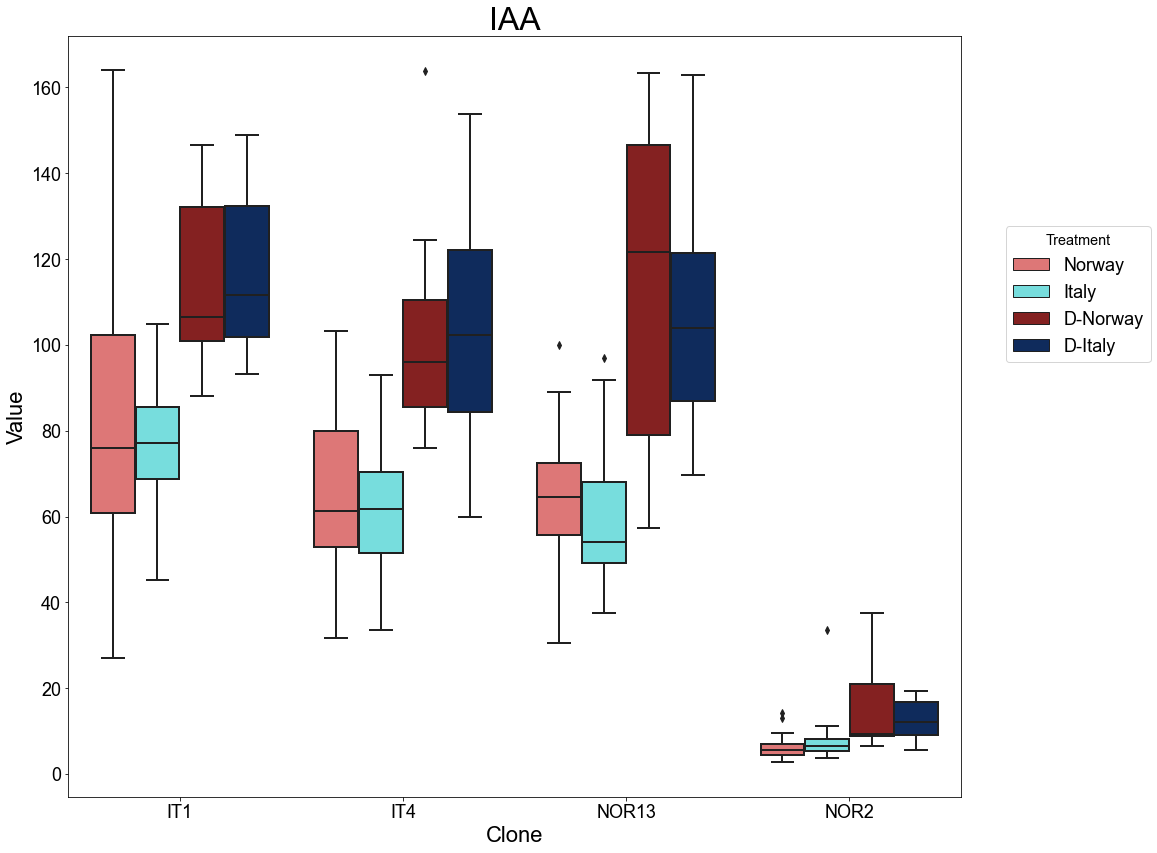

In [81]:
fig = pp.figure(figsize=(16,14))
ax = sb.boxplot(x='Clone', y='Value', hue = 'Treatment', data = IAA)
pp.title('IAA')
pp.legend(bbox_to_anchor=(1.05, 0.75), loc=2, borderaxespad=0., title = 'Treatment', fontsize=18)
pp.savefig('Hormone_results_figures/Boxplot_IAA.png', bbox_inches='tight', dpi=300)
pp.show()

In [83]:
## Just Norway vs Italy (no dark treatment)

# fig = pp.figure(figsize=(16,14))
# ax = sb.boxplot(x='Clone', y='Value', hue = 'Treatment', data = drop_dark(IAA))
# pp.title('IAA')
# # pp.legend(bbox_to_anchor=(1.05, 0.75), loc=2, borderaxespad=0., title = 'Treatment', fontsize=18)
# pp.savefig('Hormone_results_figures/Boxplot_IAA_light.png', bbox_inches='tight', dpi=300)
# pp.show()

In [85]:
anova_table(IAA)

,sum_sq,df,F,PR(>F)
C(Clone),395672.663046,3.0,374.536504,2.136010e-116
C(Treatment),98223.226800,3.0,92.976310,8.573792e-46
C(Clone):C(Treatment),21476.146541,9.0,6.776309,4.439899e-09
Residual,142618.433405,405.0,NaN,NaN


In [86]:
IAA_tukey = tukey_results(IAA)
IAA_tukey

,meandiff,p-adj,lower,upper,reject,Clone_1,Clone_2,Treatment
11,-102.9225,0.0000,-126.6007,-79.2442,True,IT1,NOR2,D-Italy
26,-98.5420,0.0000,-125.0484,-72.0356,True,IT1,NOR2,D-Norway
32,-15.6646,0.0230,-30.3165,-1.0126,True,IT1,IT4,Italy
36,-18.8040,0.0013,-33.4559,-4.1520,True,IT1,NOR13,Italy
40,-69.6948,0.0000,-85.2634,-54.1262,True,IT1,NOR2,Italy
45,-18.3306,0.0021,-32.9826,-3.6786,True,IT1,IT4,Norway
49,-19.2537,0.0008,-33.9057,-4.6017,True,IT1,NOR13,Norway
53,-77.6325,0.0000,-92.5866,-62.6784,True,IT1,NOR2,Norway
61,-90.7429,0.0000,-113.6183,-67.8675,True,IT4,NOR2,D-Italy
72,-83.9535,0.0000,-108.4710,-59.4361,True,IT4,NOR2,D-Norway


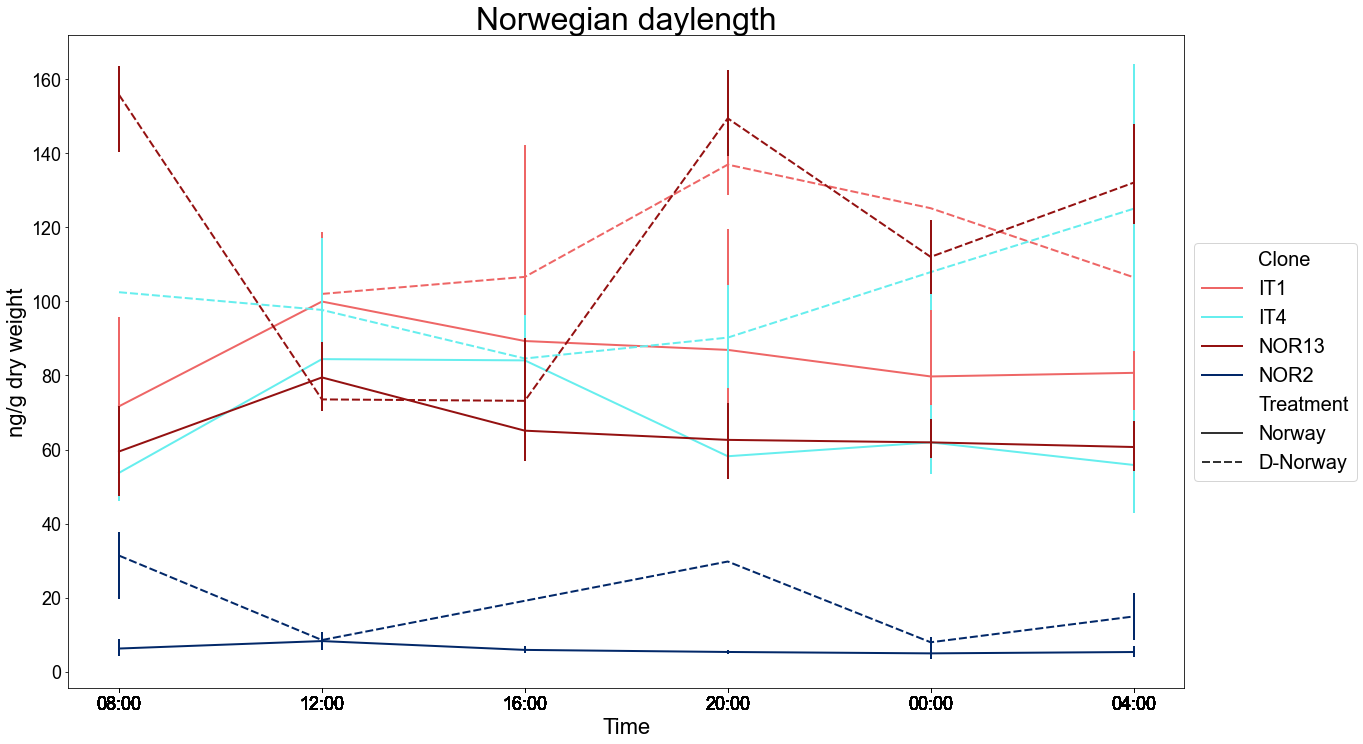

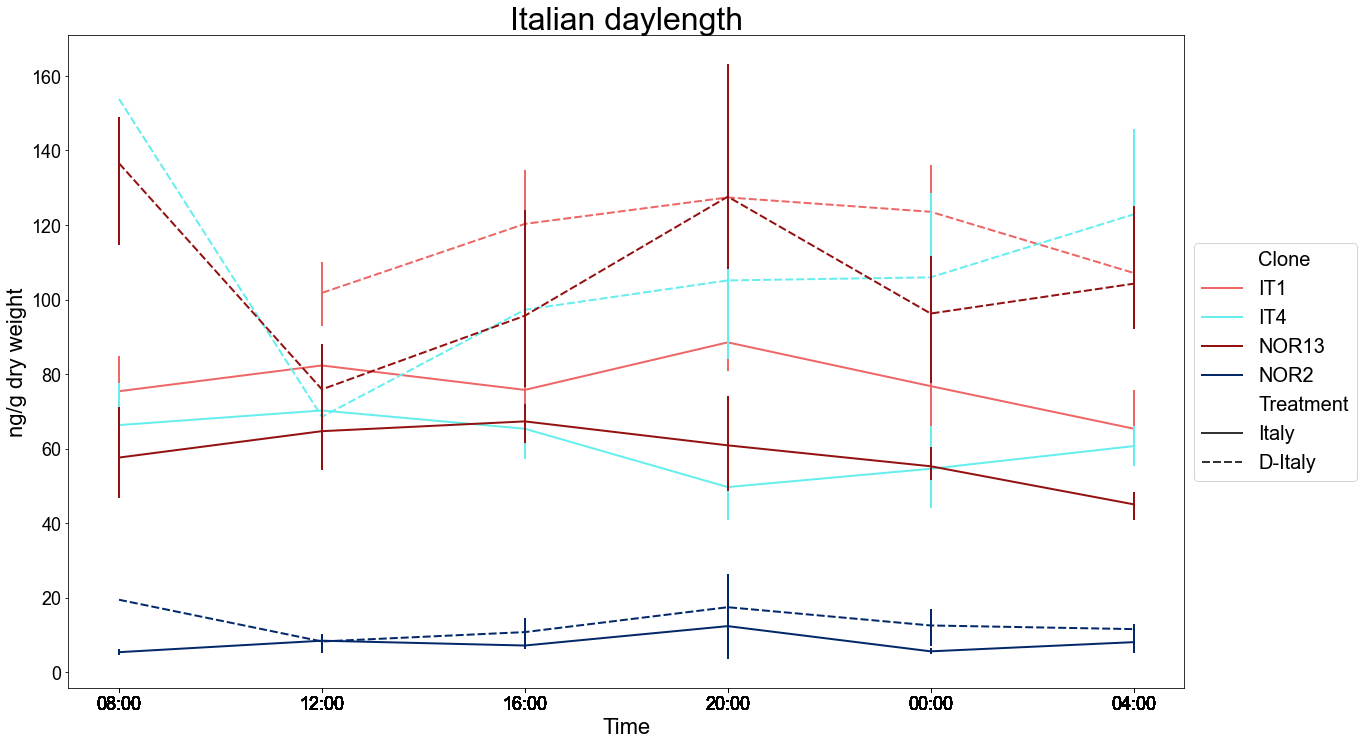

In [87]:
plot_hormone_clocktime(IAA)

In [88]:
# zt_IAA = plot_hormone_zeitgeber(IAA)
# zt_IAA.savefig("Hormone_results_figures/zt_IAA.png", dpi=300, bbox_inches='tight')

In [90]:
# zt_IAA_No = plot_hormone_zeitgeber_No(IAA)
# zt_IAA_No.savefig("Hormone_results_figures/zt_IAA_No.png", dpi=300, bbox_inches='tight')

In [91]:
# zt_IAA_It = plot_hormone_zeitgeber_It(IAA)
# zt_IAA_It.savefig("Hormone_results_figures/zt_IAA_It.png", dpi=300, bbox_inches='tight')

In [92]:
display_significant_t_tests(IAA)

Significant differences between Norwegian and Italian treatments


,,Ttest_ind,p-value
Clock_time,Clone,,
04:00,NOR13,3.763714,0.003700
16:00,IT4,3.653121,0.004439


Significant difference between Italian and Norwegian clones


C:\Users\cfa024\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\cfa024\Anaconda3\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Ttest_ind   p-value
Clock_time Treatment                     
00:00      D-Italy     2.578630  0.029763
           Italy       2.734492  0.013170
           Norway      3.218929  0.003952
04:00      D-Italy     2.522999  0.030232
           Italy       4.670667  0.000167
           Norway      3.032539  0.006115
08:00      Italy       5.033551  0.000016
           Norway      3.091252  0.003963
12:00      D-Italy     2.463494  0.033476
           D-Norway    3.849846  0.003213
           Italy       4.212658  0.000359
           Norway      3.879384  0.000809
16:00      D-Italy     2.623134  0.025460
           Italy       3.387237  0.002651
           Norway      5.253646  0.000029
20:00      Italy       2.460059  0.023118

Significant difference between Norwegian and Dark treatments by latitudinal origin


C:\Users\cfa024\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\cfa024\Anaconda3\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Ttest_ind   p-value
Clock_time Clone                     
00:00      IT4    -4.490730  0.004145
           NOR13  -7.154651  0.000376
04:00      IT4    -3.817108  0.006567
           NOR13  -9.543404  0.000029
           NOR2   -3.868549  0.006143
08:00      NOR13  -7.840945  0.000014
           NOR2   -6.939133  0.000040
20:00      IT4    -4.371188  0.003269
           NOR13  -9.364202  0.000033

Significant difference between Italian and Dark treatments by latitudinal origin


C:\Users\cfa024\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\cfa024\Anaconda3\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Ttest_ind   p-value
Clock_time Clone                     
00:00      IT1    -3.029115  0.023124
           IT4    -4.356662  0.003328
           NOR13  -5.580349  0.000833
04:00      IT1    -4.060973  0.004804
           IT4    -6.840555  0.000244
           NOR13  -8.032441  0.000089
08:00      NOR13  -6.353764  0.000083
12:00      IT1    -3.877858  0.006070
16:00      IT1    -4.755750  0.002070
           IT4    -4.639752  0.002370
           NOR13  -2.758268  0.028166
20:00      IT1    -3.347330  0.012296
           IT4    -4.129423  0.004407
           NOR13  -4.286594  0.003626

# Abscissic acid (ABA)

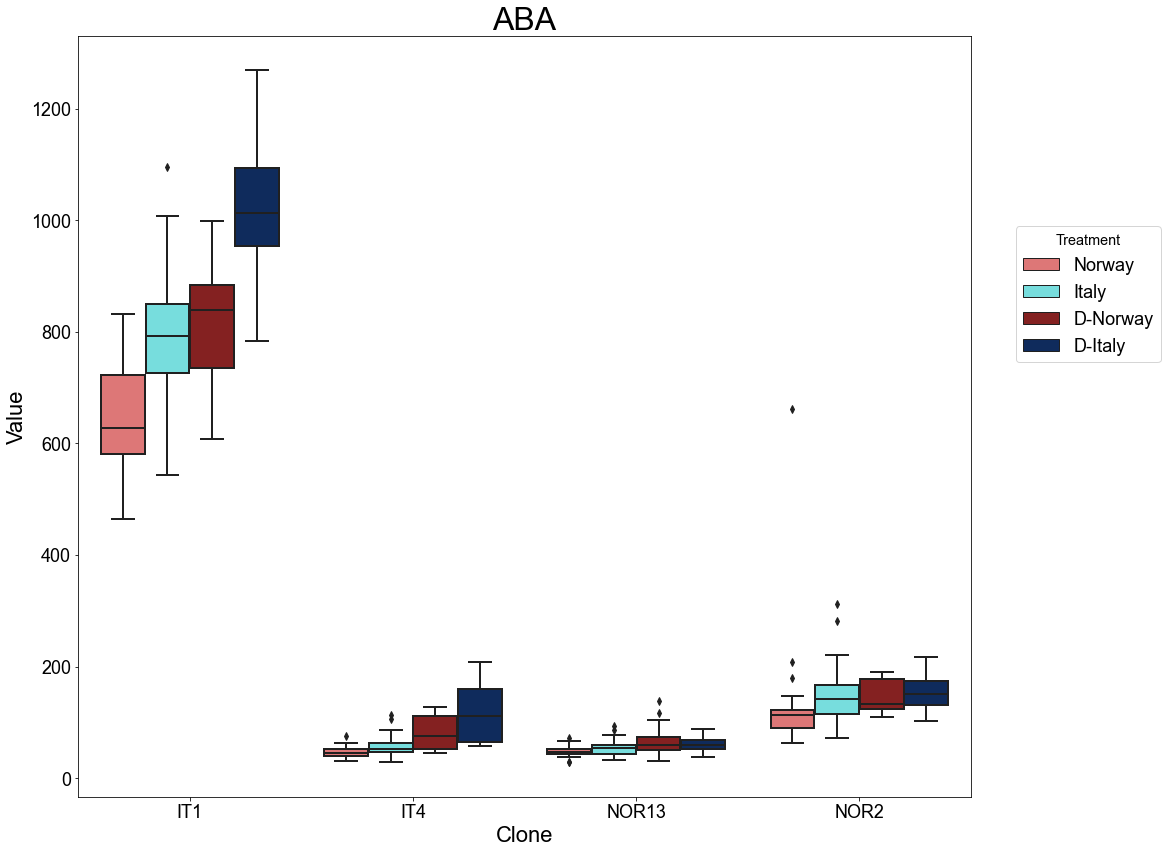

In [93]:
fig = pp.figure(figsize=(16,14))
ax = sb.boxplot(x='Clone', y='Value', hue = 'Treatment', data = ABA)
pp.title('ABA')
pp.legend(bbox_to_anchor=(1.05, 0.75), loc=2, borderaxespad=0., title = 'Treatment', fontsize=18)
pp.savefig('Hormone_results_figures/Boxplot_ABA.png', bbox_inches='tight', dpi=300)
pp.show()

In [94]:
## Just Norway vs Italy (no dark treatment)

# fig = pp.figure(figsize=(16,14))
# ax = sb.boxplot(x='Clone', y='Value', hue = 'Treatment', data = drop_dark(ABA))
# pp.title('Average Abscissic Acid Levels')
# # pp.legend(bbox_to_anchor=(1.05, 0.75), loc=2, borderaxespad=0., title = 'Treatment', fontsize=18)
# pp.savefig('Hormone_results_figures/Boxplot_ABA_treatment.png', bbox_inches='tight', dpi=300)
# pp.show()

In [95]:
anova_table(ABA)

,sum_sq,df,F,PR(>F)
C(Clone),4.184187e+07,3.0,3122.348090,1.421129e-288
C(Treatment),7.355437e+05,3.0,54.888166,5.394317e-30
C(Clone):C(Treatment),1.093911e+06,9.0,27.210142,4.016455e-37
Residual,1.893975e+06,424.0,NaN,NaN


In [96]:
tukey_results(ABA)

,meandiff,p-adj,lower,upper,reject,Clone_1,Clone_2,Treatment
3,-905.3070,0.0000,-982.0984,-828.5157,True,IT1,IT4,D-Italy
7,-960.1275,0.0000,-1036.9188,-883.3361,True,IT1,NOR13,D-Italy
11,-869.4725,0.0000,-946.2639,-792.6812,True,IT1,NOR2,D-Italy
18,-733.1126,0.0000,-809.9040,-656.3213,True,IT1,IT4,D-Norway
22,-747.2242,0.0000,-824.0156,-670.4329,True,IT1,NOR13,D-Norway
26,-669.9317,0.0000,-753.7824,-586.0810,True,IT1,NOR2,D-Norway
32,-740.3711,0.0000,-792.5406,-688.2016,True,IT1,IT4,Italy
36,-744.2350,0.0000,-796.4044,-692.0655,True,IT1,NOR13,Italy
40,-650.6810,0.0000,-706.1141,-595.2479,True,IT1,NOR2,Italy
45,-602.9749,0.0000,-655.1444,-550.8055,True,IT1,IT4,Norway


In [97]:
# plot_hormone_clocktime(ABA)

In [98]:
# plot_hormone_zeitgeber(ABA)

In [99]:
# zt_ABA_No = plot_hormone_zeitgeber_No(ABA)
# zt_ABA_No.savefig("Hormone_results_figures/zt_ABA_No.png", dpi=300, bbox_inches='tight')

In [100]:
# zt_ABA_It = plot_hormone_zeitgeber_It(ABA)
# zt_ABA_It.savefig("Hormone_results_figures/zt_ABA_It.png", dpi=300, bbox_inches='tight')

In [101]:
display_significant_t_tests(ABA)

Significant differences between Norwegian and Italian treatments


Ttest_ind   p-value
Clock_time Clone                     
00:00      IT1    -2.956027  0.014386
           NOR13  -4.116372  0.002089
           NOR2   -3.401513  0.011419
04:00      NOR2   -2.571224  0.036942
08:00      IT1    -2.991978  0.008623
12:00      IT1    -3.881205  0.003053
           IT4    -2.389944  0.037962
16:00      IT1    -3.313320  0.007835
           NOR13  -2.606838  0.026182
           NOR2   -2.449753  0.034272

Significant difference between Italian and Norwegian clones


Ttest_ind   p-value
Clock_time Treatment                     
00:00      Italy       2.660549  0.015447
           Norway      2.863212  0.009036
04:00      D-Italy     2.283127  0.045543
           D-Norway    2.370523  0.039242
           Italy       2.594777  0.017782
           Norway      2.779479  0.010933
08:00      D-Italy     2.511802  0.030817
           Italy       3.744988  0.000668
           Norway      3.004136  0.004972
12:00      Italy       2.702920  0.012993
           Norway      2.700414  0.013066
16:00      Italy       2.867900  0.008939
           Norway      2.868526  0.008927
20:00      Italy       2.485470  0.021902
           Norway      2.539235  0.020011

Significant difference between Norwegian and Dark treatments by latitudinal origin


C:\Users\cfa024\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\cfa024\Anaconda3\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Ttest_ind   p-value
Clock_time Clone                     
00:00      IT1    -3.327827  0.012629
           IT4    -3.886235  0.006004
           NOR2   -3.092382  0.017508
04:00      IT1    -2.826289  0.025542
           IT4   -10.199305  0.000019
08:00      IT4    -6.109236  0.000114
           NOR13  -2.802183  0.018724
16:00      IT1    -2.706134  0.030368
20:00      IT4    -2.603985  0.035220
           NOR13  -5.488626  0.000918

Significant difference between Italian and Dark treatments by latitudinal origin


Ttest_ind   p-value
Clock_time Clone                     
00:00      IT1    -2.597810  0.035538
           IT4    -3.489144  0.010140
           NOR2   -3.812895  0.018893
04:00      IT1    -2.433278  0.045203
           IT4    -3.343616  0.012358
08:00      IT1    -5.121680  0.000450
           IT4    -6.857668  0.000044
16:00      IT1    -2.536052  0.038888
20:00      IT1    -3.870925  0.006124

# Salicylic acid (SA)

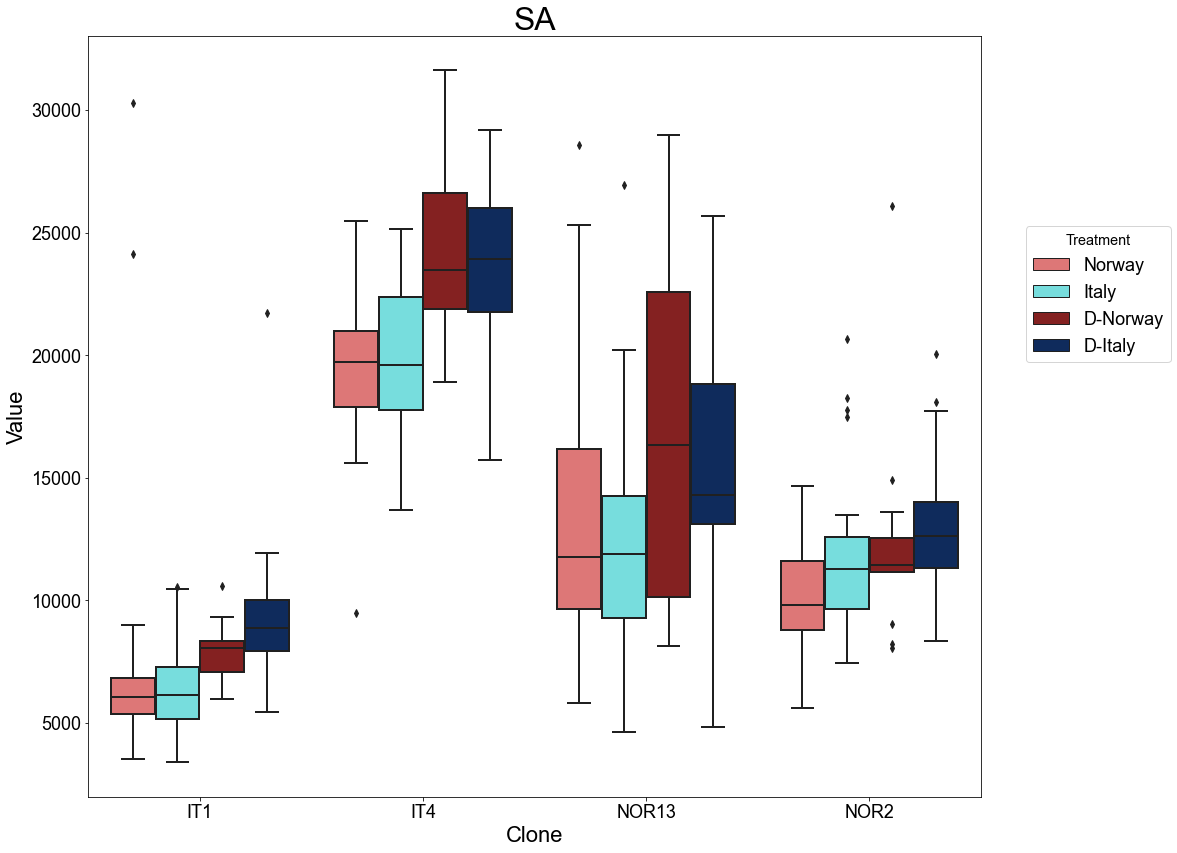

In [102]:
fig = pp.figure(figsize=(16,14))
ax = sb.boxplot(x='Clone', y='Value', hue = 'Treatment', data = SA)
pp.title('SA')
pp.legend(bbox_to_anchor=(1.05, 0.75), loc=2, borderaxespad=0., title = 'Treatment', fontsize=18)
pp.savefig('Hormone_results_figures/Boxplot_SA.png', bbox_inches='tight', dpi=300)
pp.show()

In [103]:
# ## Just Norway vs Italy (no dark treatment)

# fig = pp.figure(figsize=(16,14))
# ax = sb.boxplot(x='Clone', y='Value', hue = 'Treatment', data = drop_dark(SA))
# pp.title('Average Salicylic Acid Levels')
# # pp.legend(bbox_to_anchor=(1.05, 0.75), loc=2, borderaxespad=0., title = 'Treatment', fontsize=18)
# pp.savefig('Hormone_results_figures/Boxplot_SA_treatment.png', bbox_inches='tight', dpi=300)
# pp.show()

In [104]:
anova_table(SA)

,sum_sq,df,F,PR(>F)
C(Clone),1.088179e+10,3.0,246.465569,5.712769e-92
C(Treatment),8.630888e+08,3.0,19.548402,7.084194e-12
C(Clone):C(Treatment),2.295486e+08,9.0,1.733042,7.952275e-02
Residual,6.137041e+09,417.0,NaN,NaN


In [105]:
tukey_results(SA)

,meandiff,p-adj,lower,upper,reject,Clone_1,Clone_2,Treatment
3,14144.8207,-0.0000,9600.9257,18688.7157,True,IT1,IT4,D-Italy
7,5869.8405,0.0012,1325.9456,10413.7355,True,IT1,NOR13,D-Italy
18,16355.0258,-0.0000,11731.6397,20978.4118,True,IT1,IT4,D-Norway
22,9186.5836,0.0000,4563.1975,13809.9696,True,IT1,NOR13,D-Norway
32,13589.5452,-0.0000,10594.7456,16584.3448,True,IT1,IT4,Italy
36,5621.6321,0.0000,2626.8325,8616.4316,True,IT1,NOR13,Italy
40,5289.3862,0.0000,2107.2341,8471.5384,True,IT1,NOR2,Italy
45,12280.7734,-0.0000,9266.3356,15295.2112,True,IT1,IT4,Norway
49,6038.8517,0.0000,3024.4139,9053.2895,True,IT1,NOR13,Norway
57,-8274.9801,0.0000,-12683.2058,-3866.7545,True,IT4,NOR13,D-Italy


In [106]:
# plot_hormone_clocktime(SA)

In [54]:
# plot_hormone_zeitgeber(SA)

In [107]:
# zt_SA_No = plot_hormone_zeitgeber_No(SA)
# zt_SA_No.savefig("Hormone_results_figures/zt_SA_No.png", dpi=300, bbox_inches='tight')

In [108]:
# zt_SA_It = plot_hormone_zeitgeber_No(SA)
# zt_SA_It.savefig("Hormone_results_figures/zt_SA_It.png", dpi=300, bbox_inches='tight')

In [109]:
display_significant_t_tests(SA)

Significant differences between Norwegian and Italian treatments


,,Ttest_ind,p-value
Clock_time,Clone,,
12:00,IT4,-3.412320,0.006632
16:00,NOR13,2.948439,0.014574


Significant difference between Italian and Norwegian clones


Ttest_ind   p-value
Clock_time Treatment                     
04:00      D-Italy     3.456272  0.008615
           D-Norway    2.919632  0.022352

Significant difference between Norwegian and Dark treatments by latitudinal origin


C:\Users\cfa024\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\cfa024\Anaconda3\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Ttest_ind   p-value
Clock_time Clone                     
00:00      IT1    -2.569862  0.037015
           IT4    -5.048870  0.001482
04:00      IT4    -2.853258  0.024574
08:00      IT4    -5.858117  0.000160
           NOR2   -2.406557  0.039471
12:00      IT4    -4.775479  0.002023
16:00      IT1    -4.602799  0.002476

Significant difference between Italian and Dark treatments by latitudinal origin


C:\Users\cfa024\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\cfa024\Anaconda3\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Ttest_ind   p-value
Clock_time Clone                     
00:00      IT4    -3.840574  0.006370
04:00      NOR2   -3.815162  0.018856
08:00      IT1    -6.231846  0.000097
16:00      IT4    -2.608694  0.034980
20:00      IT1    -3.292065  0.013265
           IT4    -2.649097  0.032985
           NOR2   -2.844671  0.036048

## Jasmonic acid (JA)

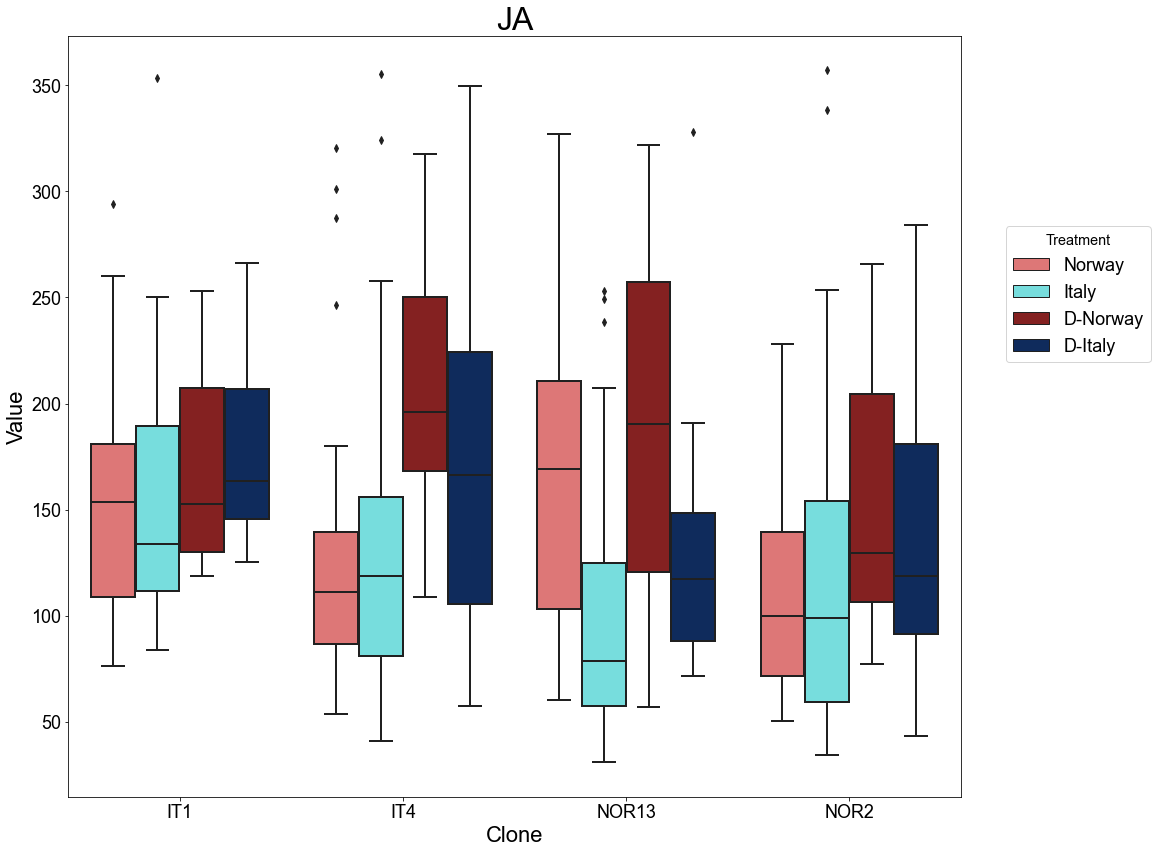

In [110]:
fig = pp.figure(figsize=(16,14))
ax = sb.boxplot(x='Clone', y='Value', hue = 'Treatment', data = JA)
pp.title('JA')
pp.legend(bbox_to_anchor=(1.05, 0.75), loc=2, borderaxespad=0., title = 'Treatment', fontsize=18)
pp.savefig('Hormone_results_figures/Boxplot_JA.png', bbox_inches='tight', dpi=300)
pp.show()

In [111]:
# ## Just Norway vs Italy (no dark treatment)

# fig = pp.figure(figsize=(16,14))
# ax = sb.boxplot(x='Clone', y='Value', hue = 'Treatment', data = drop_dark(JA))
# pp.title('Average Jasmonic Acid Levels')
# # pp.legend(bbox_to_anchor=(1.05, 0.75), loc=2, borderaxespad=0., title = 'Treatment', fontsize=18)
# pp.savefig('Hormone_results_figures/Boxplot_JA_treatment.png', bbox_inches='tight', dpi=300)
# pp.show()

In [112]:
anova_table(JA)

,sum_sq,df,F,PR(>F)
C(Clone),5.464220e+04,3.0,4.268845,5.552917e-03
C(Treatment),1.526141e+05,3.0,11.922762,1.766626e-07
C(Clone):C(Treatment),1.210604e+05,9.0,3.152557,1.104828e-03
Residual,1.629896e+06,382.0,NaN,NaN


In [113]:
tukey_results(JA)

,meandiff,p-adj,lower,upper,reject,Clone_1,Clone_2,Treatment


In [59]:
# plot_hormone_clocktime(JA)

In [60]:
# plot_hormone_zeitgeber(JA)

In [115]:
# zt_JA_No = plot_hormone_zeitgeber_No(JA)
# zt_JA_No.savefig("Hormone_results_figures/zt_JA_No.png", dpi=300, bbox_inches='tight')'

In [116]:
# zt_JA_It = plot_hormone_zeitgeber_It(JA)
# zt_JA_It.savefig("Hormone_results_figures/zt_JA_It.png", dpi=300, bbox_inches='tight')

In [117]:
display_significant_t_tests(JA)

Significant differences between Norwegian and Italian treatments


C:\Users\cfa024\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\cfa024\Anaconda3\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Ttest_ind   p-value
Clock_time Clone                     
04:00      NOR13   2.324613  0.042438
08:00      IT4    -2.708366  0.016976
           NOR2    2.358836  0.034650
12:00      NOR13   2.666894  0.032144
16:00      NOR2    2.654358  0.024132
20:00      IT4     2.527198  0.030015
           NOR13   2.231850  0.049686

Significant difference between Italian and Norwegian clones


,,Ttest_ind,p-value
Clock_time,Treatment,,
04:00,D-Italy,4.028610,0.002979
08:00,Italy,3.716058,0.001136


Significant difference between Norwegian and Dark treatments by latitudinal origin


C:\Users\cfa024\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\cfa024\Anaconda3\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,,Ttest_ind,p-value
Clock_time,Clone,,
04:00,NOR2,-2.939270,0.025972
08:00,IT4,-4.824303,0.000698
20:00,IT4,-2.921305,0.022299


Significant difference between Italian and Dark treatments by latitudinal origin


C:\Users\cfa024\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\cfa024\Anaconda3\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,,Ttest_ind,p-value
Clock_time,Clone,,
00:00,IT4,-5.569394,0.000843
04:00,IT1,-2.583913,0.036265
08:00,IT1,-2.659497,0.044911


# Jasmonic acid Isoleucine conjugate (JA-Ile)

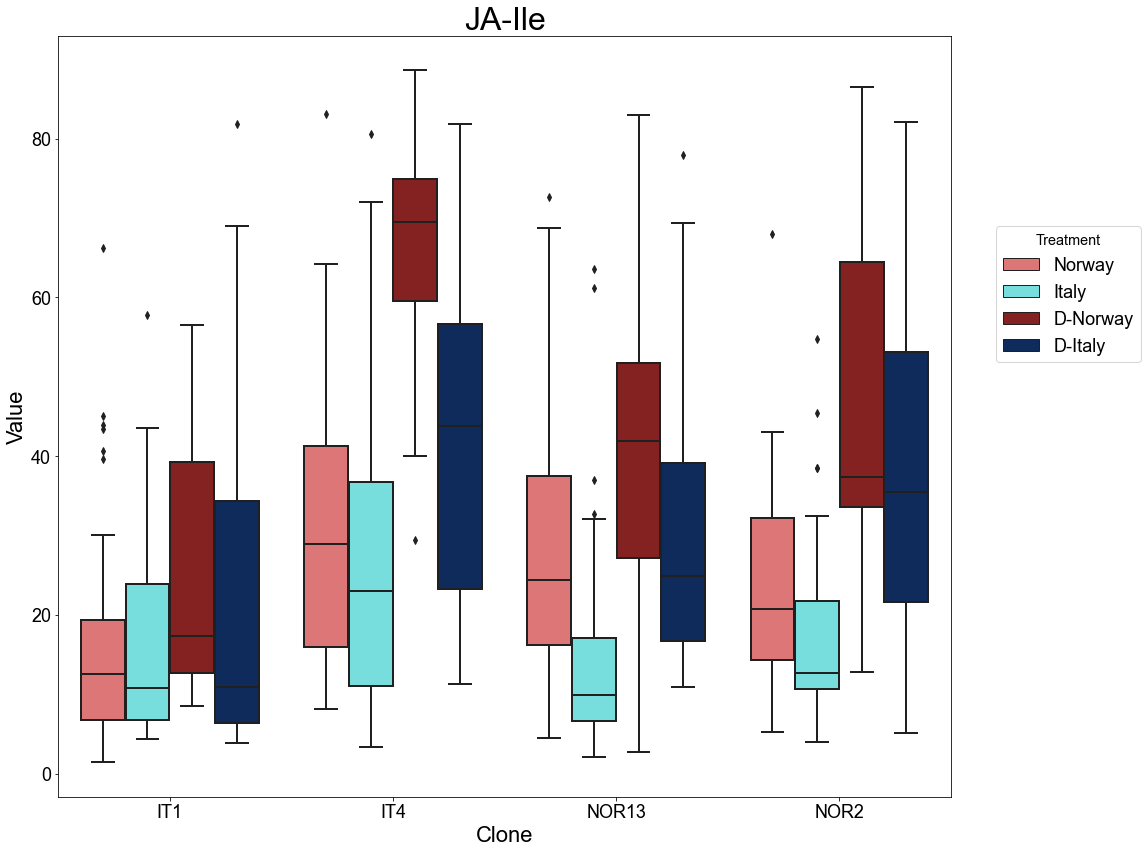

In [118]:
fig = pp.figure(figsize=(16,14))
ax = sb.boxplot(x='Clone', y='Value', hue = 'Treatment', data = JA_Ile)
pp.title('JA-Ile')
pp.legend(bbox_to_anchor=(1.05, 0.75), loc=2, borderaxespad=0., title = 'Treatment', fontsize=18)
pp.savefig('Hormone_results_figures/Boxplot_JA_Ile.png', bbox_inches='tight', dpi=300)
pp.show()

In [119]:
# ## Just Norway vs Italy (no dark treatment)

# fig = pp.figure(figsize=(16,14))
# ax = sb.boxplot(x='Clone', y='Value', hue = 'Treatment', data = drop_dark(JA_Ile))
# pp.title('Average Jasmonic Acid Isoleucine Conjugate Levels')
# # pp.legend(bbox_to_anchor=(1.05, 0.75), loc=2, borderaxespad=0., title = 'Treatment', fontsize=18)
# pp.savefig('Hormone_results_figures/Boxplot_JA_Ile_treatment.png', bbox_inches='tight', dpi=300)
# pp.show()

In [120]:
anova_table(JA_Ile)

,sum_sq,df,F,PR(>F)
C(Clone),14422.106847,3.0,15.795298,1.034745e-09
C(Treatment),28658.943153,3.0,31.387685,3.436619e-18
C(Clone):C(Treatment),6912.177192,9.0,2.523439,8.061830e-03
Residual,118393.873317,389.0,NaN,NaN


In [121]:
tukey_results(JA_Ile)

,meandiff,p-adj,lower,upper,reject,Clone_1,Clone_2,Treatment
18,38.5906,0.0000,16.6913,60.4898,True,IT1,IT4,D-Norway
68,-23.0646,0.0441,-45.8637,-0.2655,True,IT4,NOR13,D-Norway


In [65]:
# plot_hormone_clocktime(JA_Ile)

In [66]:
# plot_hormone_zeitgeber(JA_Ile)

In [122]:
# zt_JA_Ile_No = plot_hormone_zeitgeber_No(JA_Ile)
# zt_JA_Ile_No.savefig("Hormone_results_figures/zt_JA_Ile_No.png", dpi=300, bbox_inches='tight')

In [123]:
# zt_JA_Ile_It = plot_hormone_zeitgeber_No(JA_Ile)
# zt_JA_Ile_It.savefig("Hormone_results_figures/zt_JA_Ile_It.png", dpi=300, bbox_inches='tight')

In [124]:
display_significant_t_tests(JA_Ile)

Significant differences between Norwegian and Italian treatments


Ttest_ind   p-value
Clock_time Clone                     
04:00      NOR13   2.334695  0.044404
12:00      NOR13   2.522900  0.030237
           NOR2    7.531549  0.000020

Significant difference between Italian and Norwegian clones


,,Ttest_ind,p-value
Clock_time,Treatment,,
12:00,Italy,3.359177,0.002969
20:00,D-Italy,-3.711376,0.004835


Significant difference between Norwegian and Dark treatments by latitudinal origin


C:\Users\cfa024\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\cfa024\Anaconda3\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Ttest_ind   p-value
Clock_time Clone                     
00:00      NOR2   -2.816234  0.025913
04:00      IT1    -7.390995  0.000151
           NOR2   -4.100841  0.004568
08:00      NOR2   -8.310265  0.000008
12:00      IT4    -2.798655  0.026576
16:00      IT1    -2.586338  0.036137
           IT4    -5.062129  0.002306
           NOR13  -2.658958  0.032516
20:00      IT4    -3.141340  0.020034

Significant difference between Italian and Dark treatments by latitudinal origin


Ttest_ind   p-value
Clock_time Clone                     
00:00      NOR2   -2.976853  0.040866
04:00      IT1    -2.508487  0.040486
           IT4    -4.513715  0.010710
12:00      NOR13  -4.209888  0.003986
16:00      IT1    -3.359184  0.012098
20:00      NOR13  -3.089976  0.017568

# Jasmonate catabolites (OH-JA)

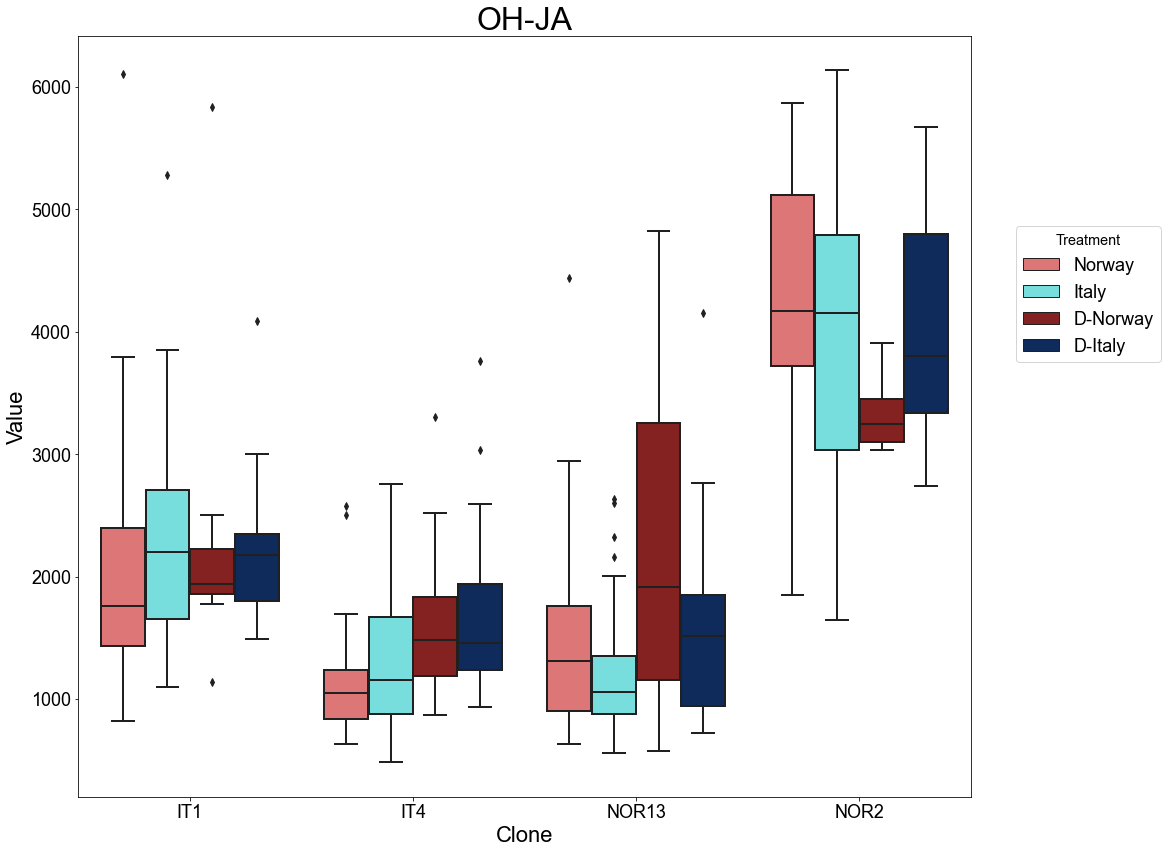

In [132]:
fig = pp.figure(figsize=(16,14))
ax = sb.boxplot(x='Clone', y='Value', hue = 'Treatment', data = OH_JA)
pp.title('OH-JA')
pp.legend(bbox_to_anchor=(1.05, 0.75), loc=2, borderaxespad=0., title = 'Treatment', fontsize=18)
pp.savefig('Hormone_results_figures/Boxplot_OH_JA.png', dpi=300)
pp.show()

In [126]:
## Just Norway vs Italy (no dark treatment)

# fig = pp.figure(figsize=(16,14))
# ax = sb.boxplot(x='Clone', y='Value', hue = 'Treatment', data = drop_dark(OH_JA))
# pp.title('Average Jasmonate Catabolite Levels')
# # pp.legend(bbox_to_anchor=(1.05, 0.75), loc=2, borderaxespad=0., title = 'Treatment', fontsize=18)
# pp.savefig('Hormone_results_figures/Boxplot_OH_JA_treatment.png', bbox_inches='tight', dpi=300)
# pp.show()

In [127]:
anova_table(OH_JA)

,sum_sq,df,F,PR(>F)
C(Clone),3.739449e+08,3.0,174.951305,6.491122e-72
C(Treatment),6.985147e+06,3.0,3.268023,2.133984e-02
C(Clone):C(Treatment),1.794913e+07,9.0,2.799186,3.407367e-03
Residual,2.785774e+08,391.0,NaN,NaN


In [128]:
tukey_results(OH_JA)

,meandiff,p-adj,lower,upper,reject,Clone_1,Clone_2,Treatment
11,1761.3330,0.0000,679.5865,2843.0795,True,IT1,NOR2,D-Italy
32,-1011.5849,0.0000,-1670.7874,-352.3824,True,IT1,IT4,Italy
36,-1039.1579,0.0000,-1698.3604,-379.9554,True,IT1,NOR13,Italy
40,1588.1232,0.0000,867.0784,2309.1679,True,IT1,NOR2,Italy
45,-908.1129,0.0005,-1580.9086,-235.3171,True,IT1,IT4,Norway
53,2232.8259,-0.0000,1491.7319,2973.9198,True,IT1,NOR2,Norway
61,2288.8209,0.0000,1251.5054,3326.1364,True,IT4,NOR2,D-Italy
72,1705.0235,0.0024,332.7841,3077.2629,True,IT4,NOR2,D-Norway
82,2599.7080,-0.0000,1878.6633,3320.7528,True,IT4,NOR2,Italy
91,3140.9387,-0.0000,2412.1630,3869.7145,True,IT4,NOR2,Norway


In [71]:
# plot_hormone_clocktime(OH_JA)

In [72]:
# plot_hormone_zeitgeber(OH_JA)

In [129]:
# zt_OH_JA_No = plot_hormone_zeitgeber_No(OH_JA)
# zt_OH_JA_No.savefig("Hormone_results_figures/zt_OH_JA_No.png", dpi=300, bbox_inches='tight')

In [130]:
# zt_OH_JA_It = plot_hormone_zeitgeber_It(OH_JA)
# zt_OH_JA_It.savefig("Hormone_results_figures/zt_OH_JA_It.png", dpi=300, bbox_inches='tight')

In [131]:
display_significant_t_tests(OH_JA)

Significant differences between Norwegian and Italian treatments


,,Ttest_ind,p-value
Clock_time,Clone,,
04:00,IT1,-2.619606,0.025615
08:00,IT4,-3.118631,0.006616


Significant difference between Italian and Norwegian clones


Ttest_ind   p-value
Clock_time Treatment                     
00:00      Norway     -2.527901  0.019161
04:00      D-Norway   -3.796641  0.006744
           Norway     -2.725147  0.013439
16:00      D-Norway    2.594493  0.035710
           Norway     -2.515697  0.019680
20:00      D-Norway   -5.225855  0.001218

Significant difference between Norwegian and Dark treatments by latitudinal origin


C:\Users\cfa024\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\cfa024\Anaconda3\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Ttest_ind   p-value
Clock_time Clone                     
00:00      NOR13  -2.790875  0.026874
04:00      IT4    -3.957269  0.005481
           NOR13  -2.643159  0.033271
08:00      IT4    -8.138407  0.000010
20:00      NOR13  -4.776242  0.002021

Significant difference between Italian and Dark treatments by latitudinal origin


Ttest_ind   p-value
Clock_time Clone                     
00:00      IT4    -4.670150  0.002287
04:00      IT4    -5.220390  0.001225
           NOR2   -4.399518  0.011696
08:00      NOR13  -2.286860  0.045255
12:00      NOR2    3.225469  0.018013